In [28]:
import sys
sys.executable

'e:\\Apps\\Anaconda\\Setup\\envs\\ml-project-env\\python.exe'

In [29]:
import numpy as np
import os
import matplotlib.pyplot as plt
plt.style.use('ggplot') # Để hình vẽ đẹp hơn một xíu ...

In [30]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [109]:
import time
import psutil

In [148]:
def get_memory_usage():
    pid = os.getpid()
    process = psutil.Process(pid)
    memory_info = process.memory_info()
    return memory_info.rss / 1024 ** 2  # Convert to MB

# Function to get current CPU usage (percentage)
def get_cpu_usage():
    pid = os.getpid()  # Get the current process ID
    process = psutil.Process(pid)
    return process.cpu_percent(interval=1)  # Measure CPU usage over 1 second

# Dataset

In [149]:
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (50000, 32, 32, 3)
y_train shape:  (50000, 1)
X_test shape:  (10000, 32, 32, 3)
y_test shape:  (10000, 1)


# Data Preparation

#### Normalization

In [150]:
X_train = X_train / 255.0
X_test = X_test / 255.0

#### Flatten Image Data

In [151]:
X_train =  X_train.reshape(X_train.shape[0], -1)
X_test =  X_test.reshape(X_test.shape[0], -1)

print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (50000, 3072)
y_train shape:  (50000, 1)
X_test shape:  (10000, 3072)
y_test shape:  (10000, 1)


#### Feature Engineering

In [152]:
num_classes = 10

y_train_onehot = tf.one_hot(y_train.flatten(), num_classes)
y_test_onehot = tf.one_hot(y_test.flatten(), num_classes)

print("y_train one-hot shape:", y_train_onehot.shape)
print("y_test one-hot shape:", y_test_onehot.shape)

y_train one-hot shape: (50000, 10)
y_test one-hot shape: (10000, 10)


# Scikit-learn (MLPClassifier)

In [153]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [154]:
sklearn_model = MLPClassifier(
    hidden_layer_sizes=(512, 256, 128), 
    activation='relu', 
    solver='adam', 
    learning_rate='constant', 
    learning_rate_init=0.001,
    random_state=42, 
    max_iter=300,
    batch_size= 128,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10
)

In [155]:
memory_usage_sklearn = 0
training_time_sklearn = 0
cpu_usage_sklearn = 0

memory_before_sklearn = get_memory_usage()
start_time_sklearn = time.time()
cpu_before_sklearn = get_cpu_usage()

sklearn_model.fit(X_train, y_train_onehot)

end_time_sklearn = time.time()
memory_after_sklearn = get_memory_usage()
cpu_after_sklearn = get_cpu_usage()

memory_usage_sklearn = memory_after_sklearn - memory_before_sklearn
training_time_sklearn = end_time_sklearn - start_time_sklearn
cpu_usage_sklearn = cpu_after_sklearn - cpu_before_sklearn

print("Before: ", memory_before_sklearn, start_time_sklearn, cpu_before_sklearn)
print("After: ", memory_after_sklearn, end_time_sklearn, cpu_after_sklearn)

print("Training Time: ", training_time_sklearn, "s")
print("Memory Usage: ", memory_usage_sklearn, "MB")
print("CPU Usage: ", cpu_usage_sklearn, "%")

Before:  1711.72265625 1734952407.9615843 0.0
After:  1771.18359375 1734953715.76246 45.3
Training Time:  1307.8008756637573 s
Memory Usage:  59.4609375 MB
CPU Usage:  45.3 %


In [156]:
cross_entropy_loss = sklearn_model.loss_
cross_entropy_loss

0.9111620932402464

In [157]:
cross_entropy_losses = sklearn_model.loss_curve_

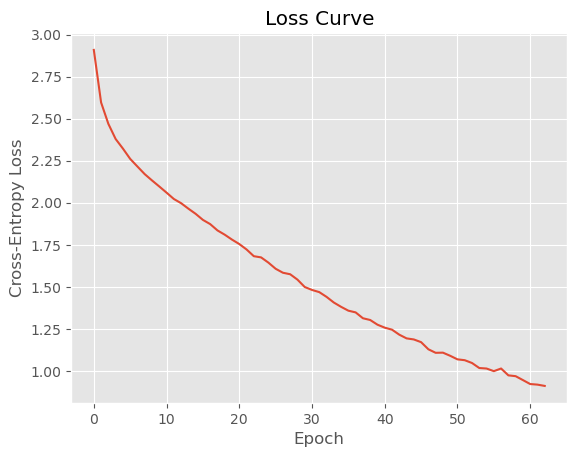

In [158]:
plt.plot(cross_entropy_losses)
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.title('Loss Curve')
plt.show()

In [170]:
y_pred = np.argmax(sklearn_model.predict_proba(X_test), axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.5283
Precision: 0.5327419531240143
Recall: 0.5283
F1-score: 0.5294796041283303


In [162]:
print("Classification Report:")
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.60      0.60      1000
           1       0.68      0.62      0.64      1000
           2       0.38      0.47      0.42      1000
           3       0.38      0.35      0.37      1000
           4       0.44      0.47      0.45      1000
           5       0.43      0.40      0.42      1000
           6       0.55      0.57      0.56      1000
           7       0.59      0.57      0.58      1000
           8       0.69      0.62      0.65      1000
           9       0.59      0.61      0.60      1000

    accuracy                           0.53     10000
   macro avg       0.53      0.53      0.53     10000
weighted avg       0.53      0.53      0.53     10000



# TensorFlow/ Keras

In [163]:
from tensorflow.keras.callbacks import EarlyStopping

In [164]:
tfk_model = models.Sequential([
    layers.Input(shape=(32*32*3,)),         # Input layer, flattened images of size 3072
    layers.Dense(512, activation='relu'),   # First hidden layer with 512 neurons
    layers.Dense(256, activation='relu'),   # Second hidden layer with 256 neurons
    layers.Dense(128, activation='relu'),   # Third hidden layer with 128 neurons
    layers.Dense(10, activation='softmax')  # Output layer with 10 units for CIFAR-10 classes
])

In [165]:
tfk_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [166]:
early_stopping = EarlyStopping(monitor='val_loss',  # Monitor validation loss
                               patience=10,  # Wait for 3 epochs without improvement
                               restore_best_weights=True)  # Restore the best weights

In [167]:
memory_usage_tfk = 0
training_time_tfk = 0
cpu_usage_tfk = 0

memory_before_tfk = get_memory_usage()
start_time_tfk = time.time()
cpu_before_tfk = get_cpu_usage()

history = tfk_model.fit(X_train, y_train_onehot, 
                        epochs=300, 
                        batch_size=128,  # Max iterations set to 300
                        validation_data=(X_test, y_test_onehot),
                        callbacks=[early_stopping])

end_time_tfk = time.time()
memory_after_tfk = get_memory_usage()
cpu_after_tfk = get_cpu_usage()

memory_usage_tfk = memory_after_tfk - memory_before_tfk
training_time_tfk = end_time_tfk - start_time_tfk
cpu_usage_tfk = cpu_after_tfk - cpu_before_tfk

print("Before: ", memory_before_tfk, start_time_tfk, cpu_before_tfk)
print("After: ", memory_after_tfk, end_time_tfk, cpu_after_tfk)

print("Training Time: ", training_time_tfk, "s")
print("Memory Usage: ", memory_usage_tfk, "MB")
print("CPU Usage: ", cpu_usage_tfk, "%")


Epoch 1/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.2582 - loss: 2.0415 - val_accuracy: 0.3945 - val_loss: 1.7042
Epoch 2/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.3875 - loss: 1.7075 - val_accuracy: 0.4232 - val_loss: 1.6175
Epoch 3/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.4280 - loss: 1.5961 - val_accuracy: 0.4502 - val_loss: 1.5479
Epoch 4/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.4535 - loss: 1.5292 - val_accuracy: 0.4433 - val_loss: 1.5623
Epoch 5/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.4644 - loss: 1.4935 - val_accuracy: 0.4504 - val_loss: 1.5468
Epoch 6/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.4842 - loss: 1.4514 - val_accuracy: 0.4886 - val_loss: 1.4368
Epoch 7/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.5002 - loss: 1.4071 - val_accuracy: 0.4814 - val_loss: 1.4531
Epoch 8/300
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.5097 - loss: 1.3727 - 

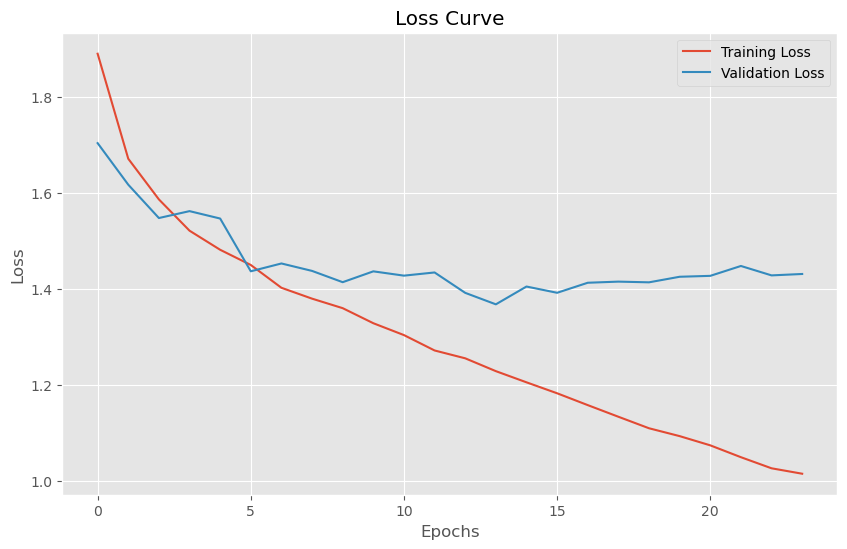

In [168]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [169]:
test_loss, test_acc = tfk_model.evaluate(X_test, y_test_onehot)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5176 - loss: 1.3672
Test Loss: 1.3678092956542969
Test Accuracy: 0.51910001039505


In [173]:
y_pred = np.argmax(tfk_model.predict(X_test), axis=1)
y_true = np.argmax(y_test_onehot, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [175]:
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.5191
Precision: 0.5177251917291078
Recall: 0.5191
F1-score: 0.5146333188730022


In [174]:
print("Classification Report:")
print(classification_report(y_true, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.60      0.60      1000
           1       0.64      0.64      0.64      1000
           2       0.43      0.36      0.39      1000
           3       0.38      0.25      0.30      1000
           4       0.45      0.46      0.45      1000
           5       0.40      0.47      0.43      1000
           6       0.49      0.62      0.55      1000
           7       0.53      0.66      0.59      1000
           8       0.66      0.59      0.62      1000
           9       0.60      0.54      0.57      1000

    accuracy                           0.52     10000
   macro avg       0.52      0.52      0.51     10000
weighted avg       0.52      0.52      0.51     10000



# PyTorch

# Time & Memory Usage

In [182]:
memory_values = [memory_usage_sklearn, memory_usage_tfk]
time_values = [training_time_sklearn, training_time_tfk]

titles = ["Scikit-learn", "TensorFlow/Keras"]

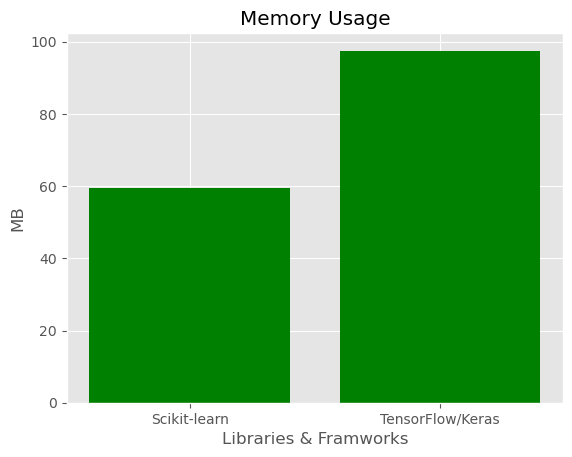

In [187]:
plt.bar(titles, memory_values, color="green")
plt.title('Memory Usage')
plt.xlabel('Libraries & Framworks')
plt.ylabel('MB')
plt.show()

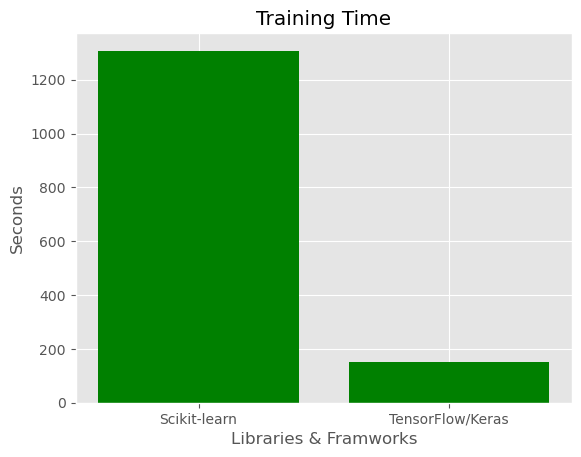

In [190]:
plt.bar(titles, time_values, color="green")
plt.title('Training Time')
plt.xlabel('Libraries & Framworks')
plt.ylabel('Seconds')
plt.show()